Below is setup for Drake

In [2]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  59.4M      0  0:00:03  0:00:03 --:--:-- 59.4M
Reading package lists...
Building dependency tree...
Reading state information...
libjpeg8 is already the newest version (8c-2ubuntu8).
libjpeg8 set to manually installed.
libjsoncpp1 is already the newest version (1.7.4-3).
libjsoncpp1 set to manually installed.
liblapack3 is already the newest version (3.7.1-4ubuntu1).
liblapack3 set to manually installed.
libogg0 is already the newest version (1.3.2-1).
libogg0 set to manually installed.
libtheora0 is already the newest version (1.1.1+dfsg.1-14).
libtheora0 set to manually installed.
libxt6 is already the newest version (1:1.1.5-1).
libxt6 set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
zlib1g is already the newest v

In [0]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import sys 
import platform
import pydrake
from pydrake.solvers import branch_and_bound

# pydrake imports
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, LinearQuadraticRegulator,
                         Linearize, AddMultibodyPlantSceneGraph, VectorSystem, le, ge, OsqpSolver)
# underactuated imports
from underactuated import FindResource

In [4]:
#clears file and downloads urdf to have it be updated
get_ipython().system(u"rm -rf /opt/hopper")
if platform.system() == "Darwin":
  get_ipython().system(u"if [ ! -d '/opt/hopper' ]; then git clone https://github.com/Olliebear/underactuated_final_project.git /opt/hopper; fi")
elif platform.linux_distribution() == ("Ubuntu", "18.04", "bionic"):
  get_ipython().system(u"if [ ! -d '/opt/hopper' ]; then git clone https://github.com/Olliebear/underactuated_final_project.git /opt/hopper; fi" )
else:
  assert False, "Unsupported platform"
sys.path.append("/opt/hopper")

Cloning into '/opt/hopper'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 15), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (31/31), done.


##Define the problem's parameters:
x0, y0 are coordinates of the foot of the 2d hopper.

th1 (theta1) is the angle between the foot and the upright, th2 is angle between bode and upright.

z0 is the distance from the hip pin joint to the foot. 

uT is torque input at pinjoint connecting leg and body. uX is length actuation on the spring in the leg. 

###Other parameters:
Spring length K_length= z0 - uX.

m1,I1,r1 = mass, inertia and radius from toe to C.O.M. for the leg

m2,I2,r2 = mass, inertia and radius from hip to C.O.M. for the body

##While on the ground:
For now, assume infinite friction. Can add friction cone constraint later, or add more modes

###Define Some System Constants
Order of states: x0, y0, th1, z0, th2

In [0]:
x_initial=[0, 3, 0, 0, 0, 0, 0, 0, 0, 0]


# weight matrices for the lqr controller
Q = np.eye(10)
R = np.eye(4)

# **Some info here**
In general, this code is a bit of a crap heap. Sorry. Lots of things/ideas going on here that I'm working on. The next few blocks though are the main part I think.

The problem is I need a better solver to actually solve my mathematical program, but I'm not sure how to get that onto this colab machine remotely. I'd imagine there's licensing issues. 

Also, it would be difficult for me to install drake on my personal computer because it would involve updating my OS (to get python 3.8)

In [5]:

builder=DiagramBuilder()
hopper, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(hopper).AddModelFromFile('/opt/hopper/hopper.urdf')
hopper.Finalize()
hopper=hopper.ToAutoDiffXd()

nq=hopper.num_positions()
nf=4 # 2 inputs ux ut and 2 contact forces

context=hopper.CreateDefaultContext()
context.SetTime(0)



5


In [0]:
def manipulator_equations(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nq + nf 
    split_at = [nq, 2 * nq, 3 * nq , 3*nq+2]
    q, qd, qdd, u, f = np.split(vars, split_at)

    u[0]=get_spring_force(q[3],u[0])

    # set compass gait state
    context = hopper.CreateDefaultContext()
    hopper.SetPositions(context, q)
    hopper.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = hopper.CalcMassMatrixViaInverseDynamics(context)
    Cv = hopper.CalcBiasTerm(context)
    tauG = hopper.CalcGravityGeneralizedForces(context)
    
    #changing to makeActuation_matrix() then multiplying that by u.
    B=hopper.MakeActuationMatrix()
    # Jacobian of the stance foot
    Jf = get_foot_jacobian(hopper, context)

    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - Jf.T.dot(f) - B.dot(u)

In [0]:
def get_foot_jacobian(hopper, context):
    
    # get reference frames for the given leg and the ground
    leg_frame = hopper.GetBodyByName('leg').body_frame()
    ground_frame = hopper.GetBodyByName('ground').body_frame()

    # compute Jacobian matrix
    J = hopper.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        leg_frame,
        np.array([0,0,0]),
        ground_frame,
        ground_frame
    )
    
    # discard y components since we are in 2D
    return J[[0, 2]]

In [0]:
def get_spring_force(z0,uX):
  k=1000 #spring constant
  kL=1 #relaxed length

  return(-k*(kL-z0+uX))

In [0]:
def get_ground_height(x):
  #use this to get the height at some position x. can change to have variable terrain
  return 0

In [0]:
def get_ground_schedule(num_steps,num_hits,density=False):
  schedule=np.zeros(num_steps)
  if density:
    schedule=None
  else:#first time running, no prescribed density
    total_num=num_hits*2+1 #starts in air, ends on ground, 
    steps_per_hit=int(num_steps/total_num)
    for i in range(total_num):
      if (i%2==1): #if odd, on the ground
        lower=i*steps_per_hit
        upper=i*steps_per_hit + steps_per_hit
        schedule[lower:upper]=np.ones(steps_per_hit)
  return schedule

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


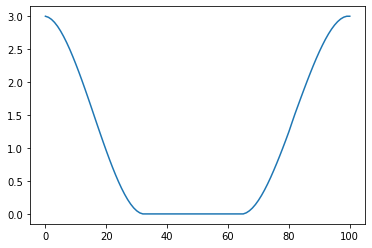

In [100]:
#FIND STEADY STATE SOLUTION AT x=0 with hopping height y_d
prog=MathematicalProgram()
N=100

y_d = 3 #desired hopping height

q_initial=[0,y_d,0,1,0]
qd_initial=[0,0,0,0,0]

h_max=.1
h_min=.01

h=prog.NewContinuousVariables(N,1,'h') #time steps
q=prog.NewContinuousVariables(N+1,5,'q')
qd=prog.NewContinuousVariables(N+1,5,'qd')
qdd=prog.NewContinuousVariables(N+1,5,'qdd')
lambdas=prog.NewContinuousVariables(N,2,'lambdas')
uZ=prog.NewContinuousVariables(N,1,'uZ')
uT=prog.NewContinuousVariables(N,1,'uT')

#make grounded variable pre-scheduled 
number_of_contacts=1
grounded=get_ground_schedule(N,number_of_contacts)
M=1000000
#print(state[0])

prog.AddLinearConstraint(eq(q[0],q_initial))
prog.AddLinearConstraint(eq(qd[0],qd_initial))

prog.AddLinearConstraint(eq(q[N],q[0]))
prog.AddLinearConstraint(eq(qd[N],qd[0]))

for t in range(N):
  prog.AddBoundingBoxConstraint(h_min*np.ones(1),h_max*np.ones(1),h[t])

  prog.AddConstraint(eq(q[t+1] , q[t] + h[t] * qd[t+1]))
  prog.AddConstraint(eq(qd[t+1] , qd[t] + h[t] * qdd[t]))


  var=np.concatenate((q[t],qd[t],qdd[t],uZ[t],uT[t],lambdas[t]))
  prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint
  
  #y force is > 0
  prog.AddLinearConstraint(lambdas[t,1]>=0)

  #y0 is always above ground. using get_ground_height so that we can change ground geometry
  #prog.AddConstraint(foot_height,lb=[0],ub=[(1-grounded[t])*M],vars=q[t])

  #below is complimentarity constraint
  prog.AddLinearConstraint(lambdas[t,0]<=grounded[t]*M)
  prog.AddLinearConstraint(lambdas[t,0]>=-1*grounded[t]*M)

  #if touching ground, xdot = 0, ydot=0, y=0

  prog.AddLinearConstraint(lambdas[t,1]<=grounded[t]*M)
  prog.AddLinearConstraint(q[t,1]-get_ground_height(q[t,0])<=(1-grounded[t])*M) #complimentarity
  prog.AddLinearConstraint(q[t,1]-get_ground_height(q[t,0])>=0) #y is above 0
  prog.AddBoundingBoxConstraint(-1*(1-grounded[t])*M,(1-grounded[t])*M,qd[t,0])#xd is 0 on ground
  prog.AddBoundingBoxConstraint(-1*(1-grounded[t])*M,(1-grounded[t])*M,qd[t,1])#yd is 0 on ground
  #add controller cost

solver=SnoptSolver()
result=solver.Solve(prog)
h_star=result.GetSolution(h)
q_star=result.GetSolution(q)
qd_star=result.GetSolution(qd)
steps=np.linspace(0,N,N+1)
plt.figure()
plt.plot(steps,x_star[:,1])
l_star=result.GetSolution(lambdas)
print(l_star[:,0])

In [0]:
prog=MathematicalProgram()
N=400

q_initial=[10,6,0,1,0]
qdd_initial=[0,0,0,0,0]

#variance around final value
eps=0.1
q_lower=q_star[0]-np.ones(5)*eps
q_upper=q_star[0]+np.ones(5)*eps
qd_lower=qd_star[0]-np.ones(5)*eps
qd_upper=qd_star[0]+np.ones(5)*eps

h_max=.1
h_min=.01

h=prog.NewContinuousVariables(N,1,'h') #time steps
q=prog.NewContinuousVariables(N+1,5,'q')
qd=prog.NewContinuousVariables(N+1,5,'qd')
qdd=prog.NewContinuousVariables(N+1,5,'qdd')
lambdas=prog.NewContinuousVariables(N,2,'lambdas')
uZ=prog.NewContinuousVariables(N,1,'uZ')
uT=prog.NewContinuousVariables(N,1,'uT')

#make grounded variable pre-scheduled 
number_of_contacts=3
grounded=get_ground_schedule(N,number_of_contacts)

M=1000000
#print(state[0])
prog.AddLinearConstraint(eq(q[0],q_initial))
prog.AddLinearConstraint(eq(qd[0],qd_initial))
for t in range(N):
  prog.AddBoundingBoxConstraint(h_min*np.ones(1),h_max*np.ones(1),h[t])

  prog.AddConstraint(eq(q[t+1] , q[t] + h[t] * qd[t+1]))
  prog.AddConstraint(eq(qd[t+1] , qd[t] + h[t] * qdd[t]))


  var=np.concatenate((q[t],qd[t],qdd[t],uZ[t],uT[t],lambdas[t]))
  prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint
  
  #y force is > 0
  prog.AddLinearConstraint(lambdas[t,1]>=0)

  #y0 is always above ground. using get_ground_height so that we can change ground geometry
  #prog.AddConstraint(foot_height,lb=[0],ub=[(1-grounded[t])*M],vars=q[t])

  #below is complimentarity constraint
  prog.AddLinearConstraint(lambdas[t,0]<=grounded[t]*M)
  prog.AddLinearConstraint(lambdas[t,0]>=-1*grounded[t]*M)

  #if touching ground, xdot = 0, ydot=0, y=0

  prog.AddLinearConstraint(lambdas[t,1]<=grounded[t]*M)
  prog.AddLinearConstraint(q[t,1]-get_ground_height(q[t,0])<=(1-grounded[t])*M) #complimentarity
  prog.AddLinearConstraint(q[t,1]-get_ground_height(q[t,0])>=0) #y is above 0
  prog.AddBoundingBoxConstraint(-1*(1-grounded[t])*M,(1-grounded[t])*M,qd[t,0])#xd is 0 on ground
  prog.AddBoundingBoxConstraint(-1*(1-grounded[t])*M,(1-grounded[t])*M,qd[t,1])#yd is 0 on ground
  #add controller cost

  prog.AddCost(uZ[t].dot(uZ[t]))
  prog.AddCost(uT[t].dot(uT[t]))

#final constraint. have q be near value that allows for periodic motion above
prog.AddBoundingBoxConstraint(q_lower, q_upper,q[N])
prog.AddBoundingBoxConstraint(qd_lower,q_upper,qd[N])

solver=SnoptSolver()
result=solver.Solve(prog)
h_t=result.GetSolution(h)
q_t=result.GetSolution(q)
qd_t=result.GetSolution(qd)

[ 2.00000000e+00  1.83605285e+00  1.67218470e+00  1.50839555e+00
  1.34467956e+00  1.18102571e+00  1.01741713e+00  8.53828847e-01
  6.90226278e-01  5.26559168e-01  3.62762165e-01  1.98744755e-01
  1.82349952e-01  1.65962205e-01  1.49581634e-01  1.42638679e-01
  1.37942050e-01  1.33432088e-01  1.29088059e-01  1.24891314e-01
  1.20824890e-01  1.16873836e-01  1.13024592e-01  1.09263989e-01
  1.05579789e-01  1.01959238e-01  9.83907933e-02  9.48618431e-02
  9.13572497e-02  8.78452862e-02  8.43254074e-02  8.07970439e-02
  7.72596009e-02  7.37124572e-02  7.01549644e-02  6.65864460e-02
  6.30061965e-02  5.94134802e-02  5.58075306e-02  5.21875488e-02
  4.85527030e-02  4.49021272e-02  4.12349200e-02  3.75629388e-02
  3.38861277e-02  3.02040650e-02  2.65160651e-02  2.28212374e-02
  1.91185332e-02  1.54067876e-02  1.16847376e-02  7.95103063e-03
  4.20425039e-03  4.42932550e-04 -3.33444294e-03 -7.12941801e-03
 -1.09436300e-02 -1.47939227e-02 -1.86819688e-02 -2.26094990e-02
 -2.65783034e-02 -3.05902

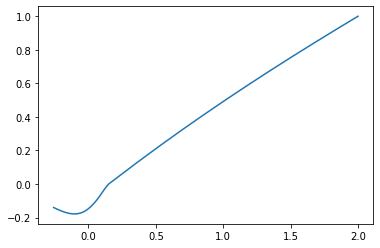

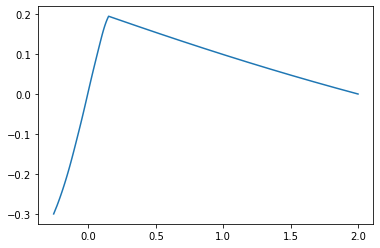

In [72]:
steps=np.linspace(0,N,N+1)
plt.figure()
plt.plot(q_t[:,0],q_t[:,1])
plt.figure()
plt.plot(steps,q_t[:,2])